In [1]:
# 필요 라이브러리 로드
from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3,os
import pandas as pd
import platform
from autogluon.tabular import TabularDataset, TabularPredictor
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
if platform.system() == 'Windows':
# 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf"
                                           ).get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

#그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
plt.rcParams['axes.unicode_minus'] == False

c:\Users\ban05\anaconda3\envs\machine_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

In [2]:
conn = sqlite3.connect('2011_2021_weather1.db')
cur = conn.cursor()

In [3]:
df_weather = pd.read_sql_query('SELECT * FROM weather2', conn)
df_weather.fillna(value = 0)
df_weather.drop(columns = ['field1','지점'], inplace =True)

In [4]:
df_weather.head(5)

,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,속초,2011-01-01 0:00,-4.6,None,4.4,32.0
1,속초,2011-01-01 1:00,-5.0,None,3.8,43.0
2,속초,2011-01-01 2:00,-4.5,None,4.2,45.0
3,속초,2011-01-01 3:00,-2.7,None,2.9,43.0
4,속초,2011-01-01 4:00,-1.7,None,3.0,45.0


In [5]:
path = 'processing_data/시간별_전력데이터.csv'
# blackout_df = pd.read_excel(path1)
df_power = pd.read_csv(path, encoding='cp949')
df_power.drop(columns = 'Unnamed: 0', inplace =True)

In [6]:
a =df_weather['지점명'].value_counts().to_dict()
print(a)

{'대전': 105192, '부산': 105192, '수원': 105192, '목포': 105191, '울릉도': 105191, '북강릉': 105191, '전주': 105190, '울산': 105190, '창원': 105190, '안동': 105190, '제주': 105190, '원주': 105187, '백령도': 105187, '광주': 105187, '청주': 105187, '서울': 105186, '여수': 105184, '속초': 105184, '대구': 105183, '의성': 105183, '춘천': 105181, '흑산도': 105178, '밀양': 105178, '홍천': 105178, '상주': 105178, '강릉': 105176, '철원': 105175, '보은': 105175, '고흥': 105174, '구미': 105174, '충주': 105174, '서귀포': 105173, '금산': 105173, '장흥': 105172, '태백': 105171, '성산': 105171, '영월': 105169, '영천': 105169, '인천': 105168, '부안': 105167, '거창': 105167, '남해': 105166, '추풍령': 105165, '포항': 105164, '동두천': 105163, '보령': 105163, '정읍': 105160, '부여': 105159, '임실': 105159, '동해': 105159, '대관령': 105156, '인제': 105155, '문경': 105153, '천안': 105152, '양산시': 105152, '제천': 105152, '영주': 105152, '강화': 105151, '통영': 105151, '울진': 105148, '장수': 105140, '이천': 105139, '고산': 105137, '보성군': 105135, '거제': 105130, '영덕': 105127, '산청': 105126, '합천': 105126, '봉화': 105124, '양평': 105123, '진주': 105

In [7]:
# 날씨가 너무 많아서 가장 전력을 많이 사용하는 도시로 기준을 잡았습니다. 
df_weather_seoul =df_weather.loc[df_weather['지점명'] == '서울']

In [8]:
df_power.rename(columns = {'datetime' : '일시'}, inplace = True)
df_power['일시'] = pd.to_datetime(df_power['일시'])
df_weather_seoul['일시'].info()
df_weather_seoul['일시'] = pd.to_datetime(df_weather_seoul['일시'])

<class 'pandas.core.series.Series'>
Int64Index: 105186 entries, 87600 to 9165293
Series name: 일시
Non-Null Count   Dtype 
--------------   ----- 
105186 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB


C:\Users\ban05\AppData\Local\Temp\ipykernel_6732\1418353175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_seoul['일시'] = pd.to_datetime(df_weather_seoul['일시'])


여기까지는 2022년 4월 6일의 데이터가 정상적으로 나옴 

In [9]:
merge_outer = pd.merge(df_power,df_weather_seoul, how='right',on='일시')
merge_outer.sort_values(by = '일시', inplace=True)

In [10]:
# 태양광 에너지 생산량이 2018-01-01~2021-12-31있기에 이 데이터도 맞춰서 슬라이싱
start_date = pd.to_datetime('2012-06-01 00:00')
end_date = pd.to_datetime('2021-12-31 00:00')
filtered_df = merge_outer[(merge_outer['일시'] >= start_date) & (merge_outer['일시'] <= end_date)]


In [11]:
# 윤달 제거 
start_date = pd.to_datetime('2020-02-29 00:00')
end_date = pd.to_datetime('2020-02-29 23:00')
filtered_df = filtered_df[(filtered_df['일시'] < start_date) | (filtered_df['일시'] > end_date)]


In [12]:
# 2012 6월 1일 0시부터 ~ 2020년 12월 31일 24시까지
train_y_s  = filtered_df[['현재수요(MW)', '일시']].iloc[:-8760]
filtered_df.fillna(0, inplace=True)
train_y  = filtered_df['현재수요(MW)'].iloc[:-8760]
# print(train_y_s.head(1),train_y_s.tail(1))
train_y_s

,현재수요(MW),일시
12407,50990.28917,2012-06-01 00:00:00
12408,50064.35500,2012-06-01 01:00:00
12409,49986.54250,2012-06-01 02:00:00
12410,50093.08083,2012-06-01 03:00:00
12411,50456.72583,2012-06-01 04:00:00
...,...,...
87638,74330.14167,2020-12-30 20:00:00
87639,71103.80000,2020-12-30 21:00:00
87640,69894.99167,2020-12-30 22:00:00
87641,71263.70833,2020-12-30 23:00:00


In [13]:
# 2021년 1월 1일 0시부터 ~ 2021년 12월 31일 24시까지
test_y_s = filtered_df[['현재수요(MW)', '일시']].iloc[-8737:]
test_y = filtered_df['현재수요(MW)'].iloc[-8737:]
print(test_y_s.head(1),test_y_s.tail(1))

        현재수요(MW)         일시
87666  65118.275 2021-01-01           현재수요(MW)         일시
96402  69589.79167 2021-12-31


In [14]:
# 2012년 6월 1일 0시부터 ~ 2019년 12월 31일 24시까지
train_x = filtered_df.iloc[8760:]
train_x
# print(train_x['일시'].head(1),train_x['일시'].tail(1))

,공급능력(MW),현재수요(MW),공급예비력(MW),공급예비율(퍼센트),일시,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%)
21167,66967.0000,48287.08417,18679.91583,38.688845,2013-06-01 01:00:00,서울,19.6,0,1.2,49.0
21168,66595.7500,48145.44833,18450.30167,38.321357,2013-06-01 02:00:00,서울,18.8,0,0.4,51.0
21169,64637.0000,47934.75000,16702.24917,34.845892,2013-06-01 03:00:00,서울,18.4,0,0.4,53.0
21170,64637.0000,47989.35583,16647.64417,34.693859,2013-06-01 04:00:00,서울,18.1,0,0.7,55.0
21171,64637.0000,47853.74417,16783.25750,35.073178,2013-06-01 05:00:00,서울,18.1,0,0.5,55.0
...,...,...,...,...,...,...,...,...,...,...
96398,104955.0000,76285.02500,28669.90000,37.597708,2021-12-30 20:00:00,서울,-3.8,0,4.3,45.0
96399,105003.9167,73298.41667,31705.36667,43.270583,2021-12-30 21:00:00,서울,-4.5,0.0,4.7,48.0
96400,105687.1667,71655.45833,34031.72500,47.494608,2021-12-30 22:00:00,서울,-4.9,0,3.7,48.0
96401,105645.7500,72511.29167,33134.56667,45.707775,2021-12-30 23:00:00,서울,-5.2,0,3.4,42.0


In [15]:
# 2021년 1월 1일 0시부터 ~ 2021년 12월 31일 24시까지
test_x = filtered_df.iloc[-8760:]
test_x
# print(test_x['일시'].head(1),test_x['일시'].tail(1))

,공급능력(MW),현재수요(MW),공급예비력(MW),공급예비율(퍼센트),일시,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%)
87643,98027.57500,66577.35833,31474.25000,47.275842,2020-12-31 01:00:00,서울,-12.6,0,1.9,50.0
87644,98060.99167,66289.10833,31803.82500,47.978425,2020-12-31 02:00:00,서울,-12.6,0,3.2,50.0
87645,98244.80833,66403.89167,31845.20000,47.958350,2020-12-31 03:00:00,서울,-12.6,0,2.2,51.0
87646,98308.20833,67212.23333,31091.19167,46.262617,2020-12-31 04:00:00,서울,-12.6,0,2.3,52.0
87647,98280.69167,68192.27500,30088.35000,44.128400,2020-12-31 05:00:00,서울,-12.6,0,2.2,54.0
...,...,...,...,...,...,...,...,...,...,...
96398,104955.00000,76285.02500,28669.90000,37.597708,2021-12-30 20:00:00,서울,-3.8,0,4.3,45.0
96399,105003.91670,73298.41667,31705.36667,43.270583,2021-12-30 21:00:00,서울,-4.5,0.0,4.7,48.0
96400,105687.16670,71655.45833,34031.72500,47.494608,2021-12-30 22:00:00,서울,-4.9,0,3.7,48.0
96401,105645.75000,72511.29167,33134.56667,45.707775,2021-12-30 23:00:00,서울,-5.2,0,3.4,42.0


y 값에 일시에 칼럼을 넣었을 때 사용하는 것 

In [16]:
train_x.columns

Index(['공급능력(MW)', '현재수요(MW)', '공급예비력(MW)', '공급예비율(퍼센트)', '일시', '지점명',
       '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)'],
      dtype='object')

In [17]:
train_x.rename(columns = {'현재수요(MW)':'1년전 수요(MW)'}, inplace=True)
test_x.rename(columns = {'현재수요(MW)':'1년전 수요(MW)'}, inplace=True)

C:\Users\ban05\AppData\Local\Temp\ipykernel_6732\2081103497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x.rename(columns = {'현재수요(MW)':'1년전 수요(MW)'}, inplace=True)
C:\Users\ban05\AppData\Local\Temp\ipykernel_6732\2081103497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x.rename(columns = {'현재수요(MW)':'1년전 수요(MW)'}, inplace=True)


In [18]:
test_x.head(2)

,공급능력(MW),1년전 수요(MW),공급예비력(MW),공급예비율(퍼센트),일시,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%)
87643,98027.57500,66577.35833,31474.250,47.275842,2020-12-31 01:00:00,서울,-12.6,0,1.9,50.0
87644,98060.99167,66289.10833,31803.825,47.978425,2020-12-31 02:00:00,서울,-12.6,0,3.2,50.0


2년치 2018~2019년도까지 날씨 데이터를 사용하여 
수요 데이터를 예측 

In [19]:
train_x.reset_index(inplace=True)
test_x.reset_index(inplace=True)

In [ ]:
train_x.to_csv('train_x.csv', encoding= 'cp949')
train_y.to_frame().reset_index().to_csv('train_y.csv', encoding= 'cp949')
test_x.to_csv('test_x.csv', encoding= 'cp949')
test_y.to_frame().reset_index().to_csv('test_y.csv', encoding= 'cp949')

In [20]:
train = pd.concat([train_x, train_y.to_frame().reset_index()], axis=1)
test = pd.concat([test_x, test_y.to_frame().reset_index()], axis=1)
test = test.drop(columns = ['index','지점명'])
train = train.drop(columns = ['index','지점명'])
test= test.astype({'강수량(mm)':float})
# test.tail(20)

In [21]:
test.to_csv('test.csv', encoding= 'cp949')
train.to_csv('train.csv', encoding= 'cp949')

In [21]:
test.columns

Index(['공급능력(MW)', '1년전 수요(MW)', '공급예비력(MW)', '공급예비율(퍼센트)', '일시', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '습도(%)', '현재수요(MW)'],
      dtype='object')

In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   공급능력(MW)    8760 non-null   float64       
 1   1년전 수요(MW)  8760 non-null   float64       
 2   공급예비력(MW)   8760 non-null   float64       
 3   공급예비율(퍼센트)  8760 non-null   float64       
 4   일시          8760 non-null   datetime64[ns]
 5   기온(°C)      8760 non-null   float64       
 6   강수량(mm)     8760 non-null   float64       
 7   풍속(m/s)     8760 non-null   float64       
 8   습도(%)       8760 non-null   float64       
 9   현재수요(MW)    8737 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 684.5 KB


In [23]:
# train.columns
# train.drop(columns = 'index', inplace = True)
train.columns

Index(['공급능력(MW)', '1년전 수요(MW)', '공급예비력(MW)', '공급예비율(퍼센트)', '일시', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '습도(%)', '현재수요(MW)'],
      dtype='object')

In [24]:
# hyperparameters = {'NN': {'num_epochs': 5000}, 'GBM': {'num_boost_round': 5000}}
# predictor = TabularPredictor(label='현재수요(MW)', hyperparameters=hyperparameters).fit(train)
predictor = TabularPredictor(label='현재수요(MW)').fit(train)

No path specified. Models will be saved in: "AutogluonModels\ag-20230329_003557\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230329_003557\"
AutoGluon Version:  0.7.0
Python Version:     3.8.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Train Data Rows:    75212
Train Data Columns: 9
Label Column: 현재수요(MW)
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (92375.44167, 0.0, 61411.70278, 8079.08037)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1954.45 MB
	Train Data (Origi

[1000]	valid_set's rmse: 3097.71
[2000]	valid_set's rmse: 2797.74
[3000]	valid_set's rmse: 2631.11
[4000]	valid_set's rmse: 2521.76
[5000]	valid_set's rmse: 2438.16
[6000]	valid_set's rmse: 2375.26
[7000]	valid_set's rmse: 2323.31
[8000]	valid_set's rmse: 2281.47
[9000]	valid_set's rmse: 2243.99
[10000]	valid_set's rmse: 2209.26


	-2209.2639	 = Validation score   (-root_mean_squared_error)
	15.92s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 2425.68
[2000]	valid_set's rmse: 2191.26
[3000]	valid_set's rmse: 2090.67
[4000]	valid_set's rmse: 2035.45
[5000]	valid_set's rmse: 1990.81
[6000]	valid_set's rmse: 1959.51
[7000]	valid_set's rmse: 1937.72
[8000]	valid_set's rmse: 1920.33
[9000]	valid_set's rmse: 1905.15
[10000]	valid_set's rmse: 1896.23


	-1896.1051	 = Validation score   (-root_mean_squared_error)
	14.33s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-2372.2322	 = Validation score   (-root_mean_squared_error)
	15.65s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-2133.6078	 = Validation score   (-root_mean_squared_error)
	530.54s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-2365.2799	 = Validation score   (-root_mean_squared_error)
	3.13s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-2926.6726	 = Validation score   (-root_mean_squared_error)
	101.7s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: XGBoost ...
	-1924.2529	 = Validation score   (-root_mean_squared_error)
	61.58s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-2529.7053	 = Validation score   (-root_mean_squared_error)
	806.54s	 = Training   runt

[1000]	valid_set's rmse: 2108.69
[2000]	valid_set's rmse: 1954.91
[3000]	valid_set's rmse: 1903.77
[4000]	valid_set's rmse: 1873.92
[5000]	valid_set's rmse: 1858.81
[6000]	valid_set's rmse: 1848.94
[7000]	valid_set's rmse: 1842.89
[8000]	valid_set's rmse: 1837.77
[9000]	valid_set's rmse: 1834.87
[10000]	valid_set's rmse: 1832.57


	-1832.5573	 = Validation score   (-root_mean_squared_error)
	28.77s	 = Training   runtime
	0.5s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-1203.1395	 = Validation score   (-root_mean_squared_error)
	0.32s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1588.53s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230329_003557\")


In [25]:
test

,공급능력(MW),1년전 수요(MW),공급예비력(MW),공급예비율(퍼센트),일시,기온(°C),강수량(mm),풍속(m/s),습도(%),현재수요(MW)
0,98027.57500,66577.35833,31474.25000,47.275842,2020-12-31 01:00:00,-12.6,0.0,1.9,50.0,65118.27500
1,98060.99167,66289.10833,31803.82500,47.978425,2020-12-31 02:00:00,-12.6,0.0,3.2,50.0,62736.84167
2,98244.80833,66403.89167,31845.20000,47.958350,2020-12-31 03:00:00,-12.6,0.0,2.2,51.0,60973.82500
3,98308.20833,67212.23333,31091.19167,46.262617,2020-12-31 04:00:00,-12.6,0.0,2.3,52.0,59941.42500
4,98280.69167,68192.27500,30088.35000,44.128400,2020-12-31 05:00:00,-12.6,0.0,2.2,54.0,59664.61667
...,...,...,...,...,...,...,...,...,...,...
8755,104955.00000,76285.02500,28669.90000,37.597708,2021-12-30 20:00:00,-3.8,0.0,4.3,45.0,NaN
8756,105003.91670,73298.41667,31705.36667,43.270583,2021-12-30 21:00:00,-4.5,0.0,4.7,48.0,NaN
8757,105687.16670,71655.45833,34031.72500,47.494608,2021-12-30 22:00:00,-4.9,0.0,3.7,48.0,NaN
8758,105645.75000,72511.29167,33134.56667,45.707775,2021-12-30 23:00:00,-5.2,0.0,3.4,42.0,NaN


In [26]:
test_preds = predictor.predict(test)
# test_preds.sort_index()

In [27]:
ld_board = predictor.leaderboard(test, silent=True)
ld_board

ValueError: Labels cannot contain missing (nan) values. Found 23 missing label values.

In [ ]:
test_date = filtered_df['일시'].iloc[-8737:]

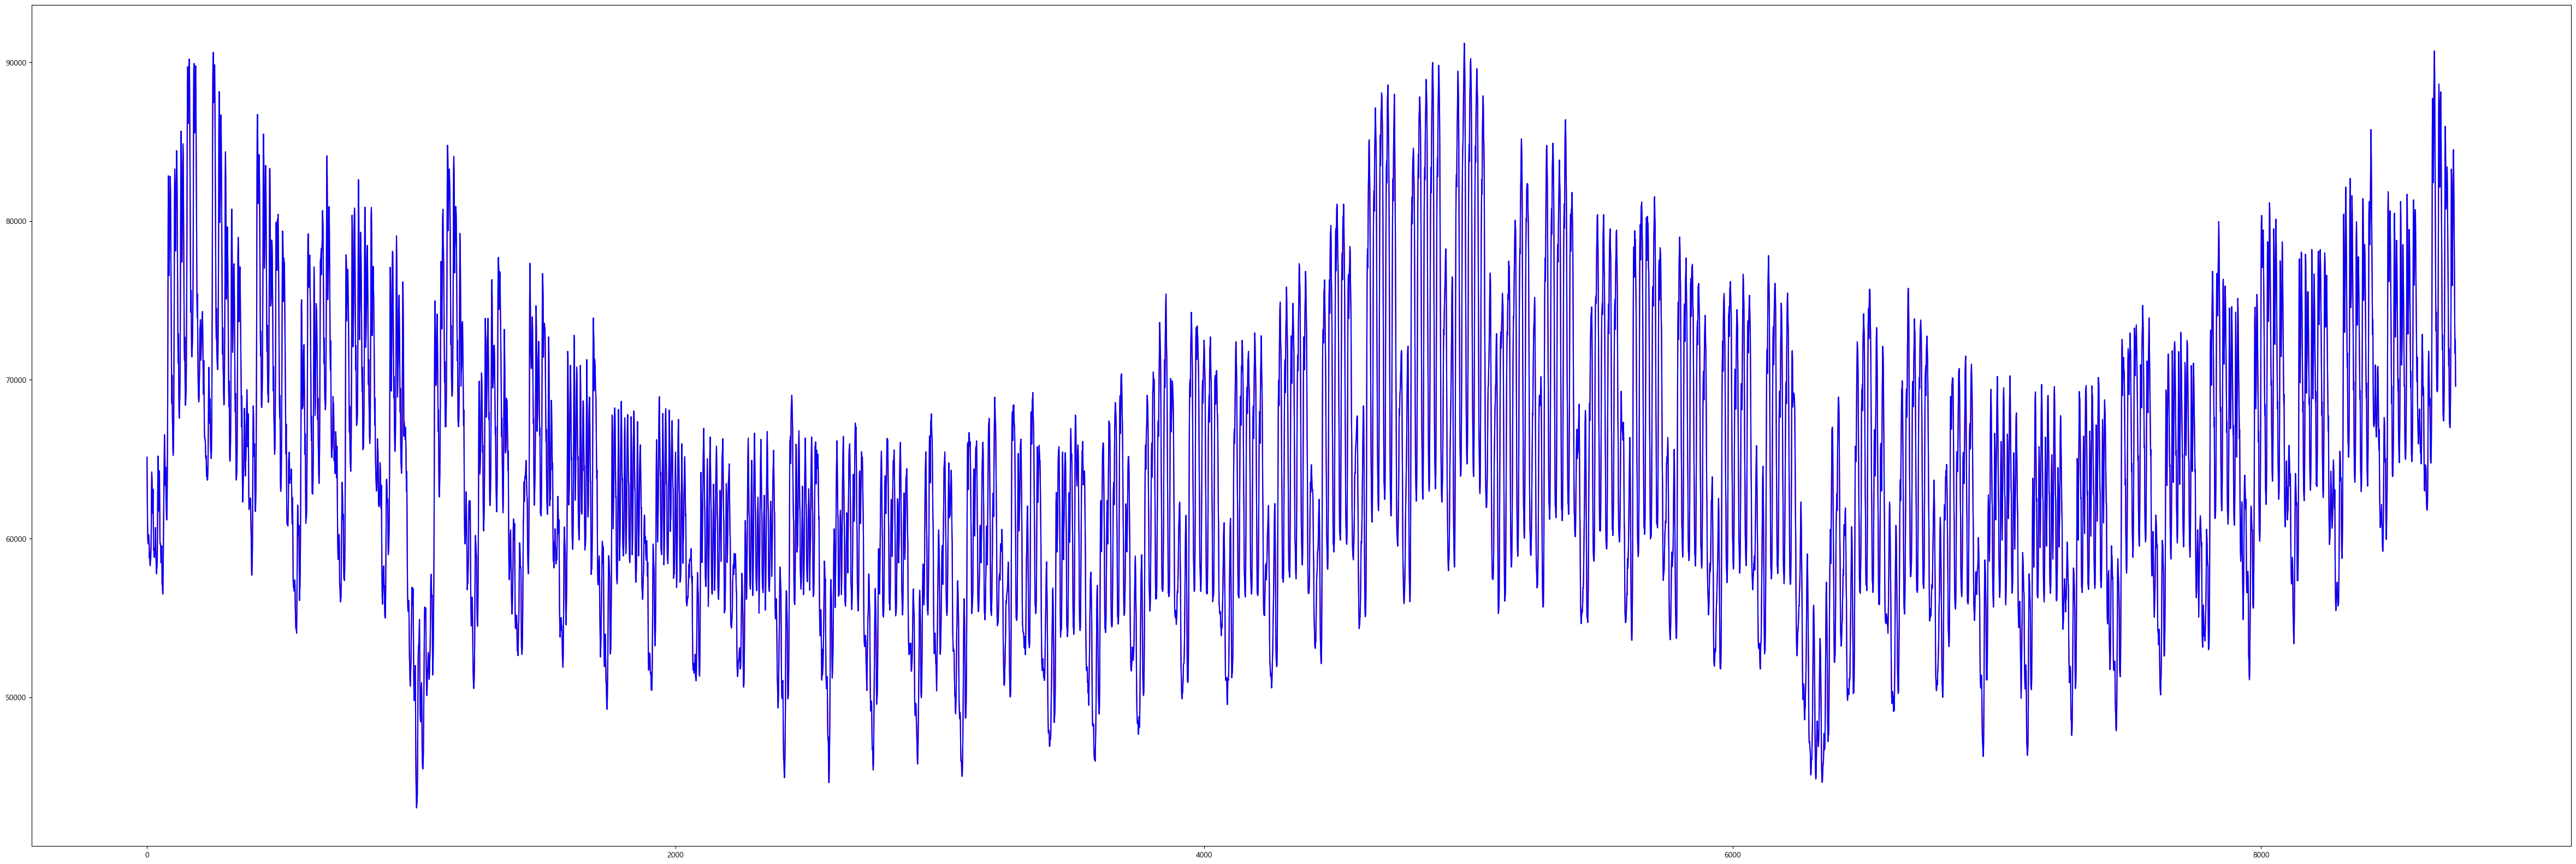

In [ ]:
fig, ax = plt.subplots(figsize=(60,20))
ax.plot(test['현재수요(MW)'], color='red', label='test_y')
ax.plot(test['1년전 수요(MW)'],color='blue', label='train_y')
plt.show()

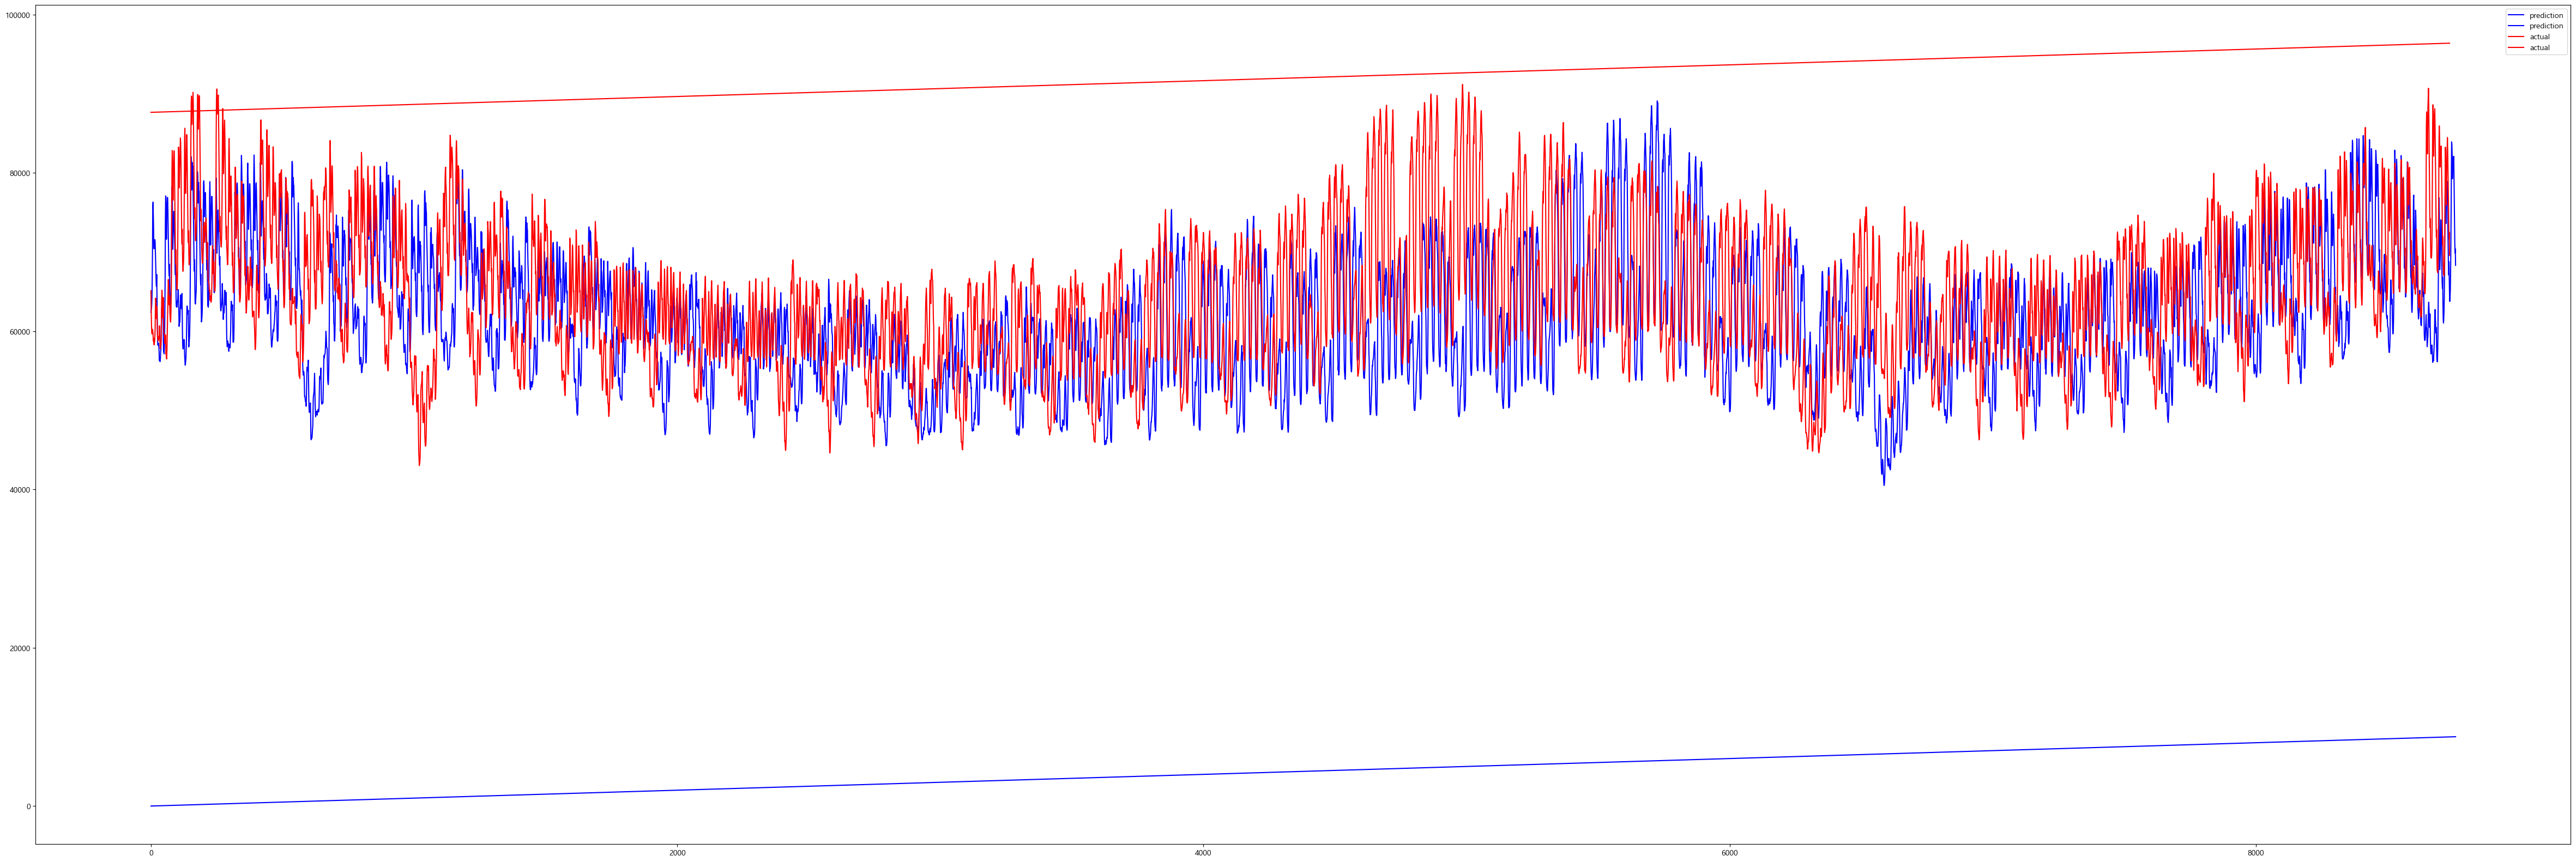

In [ ]:
# Create a figure and axes object
fig, ax = plt.subplots(figsize=(60,20))

# Plot the first value as a blue line /Value 1
ax.plot(test_preds.reset_index(), color='blue', label='prediction')

# Plot the second value as a red line /Value 2
ax.plot(test_y.reset_index(), color='red', label='actual')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Assume predicted values are stored in a pandas series called 'predicted'
# Assume actual values are stored in a pandas data frame column called 'actual'

# Calculate the margin of error (absolute difference between predicted and actual)
margin_of_error = test_preds.reset_index() - test['현재수요(MW)'].reset_index()

# Calculate the mean absolute error (MAE)
mae = margin_of_error.mean()

# Calculate the mean percentage error (MPE)
mpe = (margin_of_error / test['현재수요(MW)']).mean() * 100

# Calculate the mean squared error (MSE)
mse = np.square(margin_of_error).mean()

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Margin of error: {margin_of_error}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

Margin of error: 0        6541.725000
1        8934.494267
2       10693.940625
3       11721.926562
4       12001.594267
            ...     
8732    -4311.470312
8733    -1364.236983
8734      239.518233
8735     -607.893233
8736     2147.278642
Name: 현재수요(MW), Length: 8737, dtype: float64
MAE: 7487.286130876731
MPE: 13.692165634280187
MSE: 131187171.22617693
RMSE: 11453.696836662692


In [ ]:
margin_of_error.to_csv('pred_WeightedEnsemble_L2_model.csv' , encoding= 'cp949')

In [ ]:
margin_of_error.max()
margin_of_error.min()

-20457.725517500003

In [ ]:
margin_of_error.idxmax()

1021

In [ ]:
margin_of_error[margin_of_error<-1000]

79      -3578.651045
80     -10079.938017
81     -12488.526563
82     -11494.000517
83     -10869.042188
            ...     
8730    -7721.869795
8731    -5417.466670
8732    -4427.970312
8733    -2169.065108
8735    -1305.729170
Name: 현재수요(MW), Length: 1772, dtype: float64